In [3]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from lib.flows.elemwise import LogitTransform
from lib.plotting import get_grid, get_grid_corrector

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
eval_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
logit = LogitTransform(0.05)
reverse = logit.reverse

In [6]:
folder_path = 'save/sde-flow/default/mnist-True-True-64-0.0001-100000/'
gen_sde, optim, not_finished, count = torch.load(os.path.join(folder_path, 'checkpoint.pt'))

In [31]:
y0 = get_grid(gen_sde, 1, 28, 4, 1000, reverse)
y1 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-2)
y2 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=3e-3)
y3 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-3) # 似乎这个好
y4 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=3e-4)
y5 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-4)
y6 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=3e-5)
y7 = get_grid_corrector(gen_sde, 1, 28, 4, 1000, reverse, epsilon=1e-5)

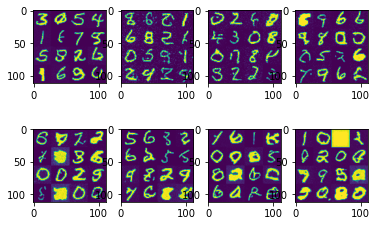

In [32]:

fig, axs = plt.subplots(2, 4)
axs[0][0].imshow(y0.squeeze())
axs[0][1].imshow(y1.squeeze())
axs[0][2].imshow(y2.squeeze())
axs[0][3].imshow(y3.squeeze())
axs[1][0].imshow(y4.squeeze())
axs[1][1].imshow(y5.squeeze())
axs[1][2].imshow(y6.squeeze())
axs[1][3].imshow(y7.squeeze())

torch.Size([2, 1, 28, 28])


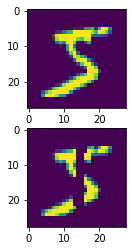

In [7]:
mask = ~(train_dataset[7896][0] > 0) # Mask: known pixels
mask.unsqueeze_(0)
data = torch.stack([train_dataset[t][0] for t in range(2)], axis=0)
print(data.shape)

fig, axs = plt.subplots(2)
axs[0].imshow(data[0].squeeze())
axs[1].imshow(data[0].squeeze() * mask.squeeze())

In [17]:
from lib.inpainting import inpaint
%load_ext autoreload
%autoreload 2
y0, y00= inpaint(gen_sde, data, mask, input_channels=1, input_height=data.shape[-1], num_steps=1000, 
         transform_forward=logit, transform_reverse=logit.reverse, debug=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
sde = gen_sde
num_steps = 1000
delta = sde.T / num_steps
mean = 0.
std = 1.
epsilon = 1e-3
transform = reverse
clip = True
input_height = data.shape[-1]
input_channels = 1
noise = torch.randn(input_channels, input_height, input_height).to(sde.T)
noise = noise * std + mean

data = data.to(sde.T).view(-1, input_channels, input_height, input_height)
mask = mask.to(sde.T).view(-1, 1, input_height, input_height)

data = data * 255 / 256 + torch.rand_like(data) / 256
data_transformed = LogitTransform(0.05).forward_transform(data)
y0 = noise * (1 - mask) + data_transformed * mask
y00 = y0
ts = torch.linspace(0, 1, num_steps + 1).to(y0) * sde.T
ones = torch.ones(y0.shape[0], 1, 1, 1).to(y0)


with torch.no_grad():
    for i in tqdm.trange(num_steps):
        mu = sde.mu(ones * ts[i], y0)
        sigma = sde.sigma(ones * ts[i], y0)
        y0 = y0 + (delta * mu + delta ** 0.5 * sigma * torch.randn_like(y0))
        data_perturbed = gen_sde.base_sde.sample(sde.T - ones * ts[i], data_transformed)
        y0 = y0 * (1. - mask) + data_perturbed * mask

        score = sde.a(y0, (ones * ts[i]).squeeze())
        g = sde.base_sde.g(sde.T - ones * ts[i], y0)
        y0 = y0 + (epsilon * score / g + (2 * epsilon) ** 0.5 * torch.randn_like(y0)) # Corrector
        data_perturbed = gen_sde.base_sde.sample(sde.T - ones * ts[i], data_transformed)
        y0 = y0 * (1. - mask) + data_perturbed * mask
        if torch.isnan(y0).any():
            break


if transform is not None:
    y0 = transform(y0)

if clip:
    y0 = torch.clip(y0, 0, 1)

# ou_sde.sample(ou_sde.T*50, x)

y0 = y0.data.cpu().numpy()

100%|██████████| 1000/1000 [00:18<00:00, 52.99it/s]


False

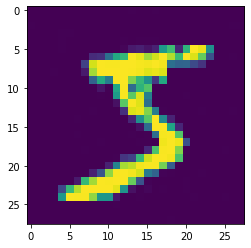

In [22]:
plt.imshow(y0[0].squeeze())
np.isnan(y0).any()